# rdkit 化学反应

Rdkit中提供了基于SMARTS的化学反应操作，可以通过SMARTS或rxn反应文件构建反应模式，再对指定的反应物进行匹配，将匹配上的结构按反应模式进行合成。

## SMARTS创建反应流程
- 从SMARTS创建一个反应模式：`Chem.ReactionFromSmarts()`
- 下面这个反应表示一个羧基，与至少带有一个氢的氮原子反应，形成酰胺
- 定义反应物：`reactants`
- 进行一个反应：`RunReactants(reactants, maxProducts)`
- 对反应物依次进行反应，返回结果为一个元组




In [14]:
rxn.RunReactants?

Docstring:
RunReactants( (ChemicalReaction)self, (tuple)reactants [, (int)maxProducts=1000]) -> object :
    apply the reaction to a sequence of reactant molecules and return the products as a tuple of tuples.  If maxProducts is not zero, stop the reaction when maxProducts have been generated [default=1000]

    C++ signature :
        _object* RunReactants(RDKit::ChemicalReaction*,boost::python::tuple [,unsigned int=1000])

RunReactants( (ChemicalReaction)self, (list)reactants [, (int)maxProducts=1000]) -> object :
    apply the reaction to a sequence of reactant molecules and return the products as a tuple of tuples.  If maxProducts is not zero, stop the reaction when maxProducts have been generated [default=1000]

    C++ signature :
        _object* RunReactants(RDKit::ChemicalReaction*,boost::python::list [,unsigned int=1000])
Type:      method


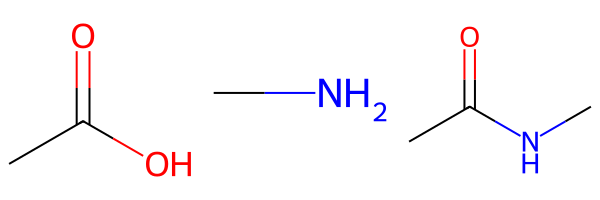

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

rxn = AllChem.ReactionFromSmarts('[C:1](=[O:2])-[OD1].[N!H0:3]>>[C:1](=[O:2])[N:3]')
reactants = (Chem.MolFromSmiles('CC(=O)O'), Chem.MolFromSmiles('NC'))
products = rxn.RunReactants(reactants)
mols = [Chem.MolFromSmiles('CC(=O)O'), Chem.MolFromSmiles('NC'),products[0][0]]

Draw.MolsToImage(mols)

In [3]:
len(products[0])

1

看看反应方程式

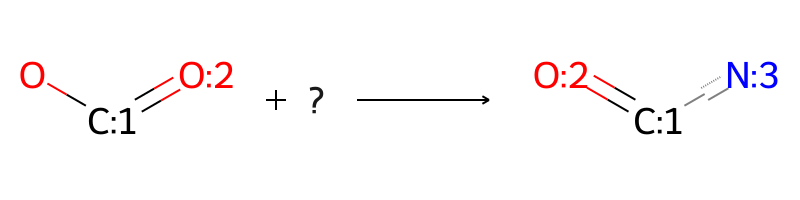

In [4]:
Draw.ReactionToImage(rxn)

用含两个羧基的化合物与甲胺反应，对应着两种匹配的方式，会产生两个反应结果。

In [5]:
double = Chem.MolFromSmiles("C(COC(=O)O)C(=O)O")
reacts = (double, Chem.MolFromSmiles('NC'))
ps = rxn.RunReactants(reacts)
ps

((<rdkit.Chem.rdchem.Mol at 0x7ffa4b9824b0>,),
 (<rdkit.Chem.rdchem.Mol at 0x7ffa4b982510>,))

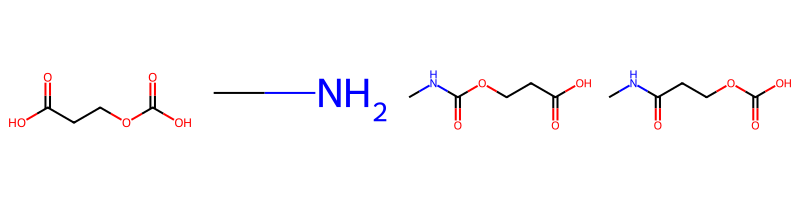

In [6]:
mols = [double, Chem.MolFromSmiles('NC'), ps[0][0], ps[1][0]]
Draw.MolsToImage(mols)

创建具体反应规则的引擎对象`rxn = AllChem.ReactionFromSmarts(tem)`
.输入反应物，借助引擎产生反应`rxn.RunReactants([productmol])`

In [13]:
def getrxns(rxn, product_smi):
    """
    获取反应规则的引擎对象
    product_smi 反应物
    """
    product_mol = Chem.MolFromSmiles(product_smi)
    reactions = rxn.RunReactants([product_mol])
    rxns = []
    for reaction in reactions:
        smis = []
        for compound in reaction:
            smi = Chem.MolToSmiles(compound)
            smis.append(smi)

        rxnstr = '.'.join(smis) + '>>' + product_smi
        # newr = canon_reaction(rxnstr)
        # rxns.append(newr)
    return rxns


tem = '([Cl;H0;D1;+0:1]-[c;H0;D3;+0:2](:[c:3]):[n;H0;D2;+0:4]:[c:5])>>(C-[n;H0;D3;+0:4](:[c:5]):[c;H0;D3;+0:2](=O):[c:3]).(Cl-P(-Cl)(=O)-[Cl;H0;D1;+0:1])'
rxn = AllChem.ReactionFromSmarts(tem)
product_smi = 'CC(C)(Nc1nc(Cl)c(-c2ccc(F)cc2)c(-c2ccncc2)n1)c1ccccc1'
reactions = getrxns(rxn, product_smi)
for reaction in reactions:
     img = Draw.ReactionStringToImage(reaction)
     display(img)


## rxn文件创建反应
通过MDL rxn文件来创建反应

In [14]:
import os
from rdkit.Chem import RDConfig
# rxn_file = os.path.join(RDConfig.RDDocsDir, 'Book\data\AmideBond.rxn')
rxn_file = "./data/AmideBond.rxn"

rxn = AllChem.ReactionFromRxnFile(rxn_file)

- 查看反应模版（反应物）数量：`GetNumReactantTemplates()`
- 查看产物模版（产物）数量：`GetNumProductTemplates()`
- 其他进行反应及查看产物的方法一样

In [15]:
print(rxn.GetNumReactantTemplates())
print(rxn.GetNumProductTemplates())


2
1


## 产物后处理
做个更复杂的反应，例如1,3丁二烯与乙烯加成反应

In [9]:
rxn = AllChem.ReactionFromSmarts('[C:1]=[C:2].[C:3]=[*:4][*:5]=[C:6]>>[C:1]1[C:2][C:3][*:4]=[*:5][C:6]1')
ps = rxn.RunReactants((Chem.MolFromSmiles('OC=C'), Chem.MolFromSmiles('C=CC(N)=C')))
len(ps)

4

查看一下产生的所有分子
反应物在反应模板中可以有多种映射方式，所以产生了多种产物，但有一些是重复的

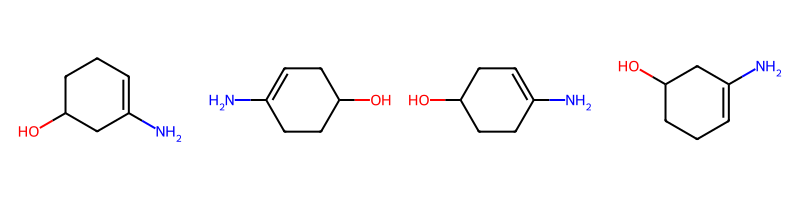

In [10]:
Chem.Draw.MolsToGridImage([x[0] for x in ps], molsPerRow=4)

可以通过字典来获得不重复的结构

In [11]:
uniqps = {}
for p in ps:
    smi = Chem.MolToSmiles(p[0])
    uniqps[smi] = p[0]
    
sorted(uniqps.keys())

['NC1=CCC(O)CC1', 'NC1=CCCC(O)C1']

此外，需要注意的是，通过化学反应产生的分子，是没有经过核对的，可以手动检查一下：`SanitizeMol()`

In [12]:
Chem.SanitizeMol(ps[0][0])
Chem.MolToSmiles(ps[0][0])



'NC1=CCCC(O)C1'